In [ ]:
!wget https://machinehack-be.s3.amazonaws.com/product_sentiment_classification_weekend_hackathon_19/Participants_Data.zip

--2020-09-05 15:25:31--  https://machinehack-be.s3.amazonaws.com/product_sentiment_classification_weekend_hackathon_19/Participants_Data.zip
Resolving machinehack-be.s3.amazonaws.com (machinehack-be.s3.amazonaws.com)... 52.219.64.32
Connecting to machinehack-be.s3.amazonaws.com (machinehack-be.s3.amazonaws.com)|52.219.64.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400578 (391K) [application/zip]
Saving to: ‘Participants_Data.zip’

Participants_Data.z 100%[===================>] 391.19K   396KB/s    in 1.0s    

2020-09-05 15:25:33 (396 KB/s) - ‘Participants_Data.zip’ saved [400578/400578]



In [ ]:
!unzip Participants_Data.zip

Archive:  Participants_Data.zip
   creating: Participants_Data/
  inflating: Participants_Data/Sample Submission.csv  
  inflating: __MACOSX/Participants_Data/._Sample Submission.csv  
  inflating: Participants_Data/Test.csv  
  inflating: __MACOSX/Participants_Data/._Test.csv  
  inflating: Participants_Data/Train.csv  
  inflating: __MACOSX/Participants_Data/._Train.csv  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
train = pd.read_csv('Participants_Data/Train.csv')
test = pd.read_csv('Participants_Data/Test.csv')
sub = pd.read_csv('Participants_Data/Sample Submission.csv')

In [ ]:
train.head(5)

,Text_ID,Product_Description,Product_Type,Sentiment
0,3057,The Web DesignerÛªs Guide to iOS (and Android...,9,2
1,6254,RT @mention Line for iPad 2 is longer today th...,9,2
2,8212,Crazy that Apple is opening a temporary store ...,9,2
3,4422,The lesson from Google One Pass: In this digit...,9,2
4,5526,RT @mention At the panel: &quot;Your mom has a...,9,2


In [ ]:
test.head(5)

,Text_ID,Product_Description,Product_Type
0,5786,RT @mention Going to #SXSW? The new iPhone gui...,7
1,5363,RT @mention 95% of iPhone and Droid apps have ...,9
2,6716,RT @mention Thank you to @mention for letting ...,9
3,4339,#Thanks @mention we're lovin' the @mention app...,7
4,66,At #sxsw? @mention / @mention wanna buy you a ...,9


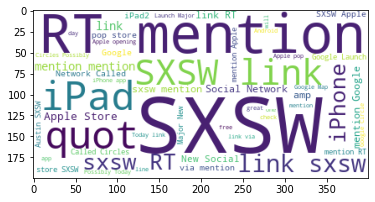

In [ ]:
from wordcloud import WordCloud, STOPWORDS
wc = WordCloud(background_color='white',
                    stopwords =  set(STOPWORDS),
                    max_words = 50, 
                    random_state = 42,)
wc.generate(' '.join(train['Product_Description']))
plt.imshow(wc)

In [ ]:
train.isnull().sum(),test.isnull().sum(),train.shape,test.shape,train.dtypes

(Text_ID                0
 Product_Description    0
 Product_Type           0
 Sentiment              0
 dtype: int64, Text_ID                0
 Product_Description    0
 Product_Type           0
 dtype: int64, (6364, 4), (2728, 3), Text_ID                 int64
 Product_Description    object
 Product_Type            int64
 Sentiment               int64
 dtype: object)

In [ ]:
df=train.append(test,ignore_index=True)

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')
#df['punctuation_count'] = df['Product_Description'].apply(lambda x: len("".join(_ for _ in x if _ in punctuation)))
df['numerics'] = df['Product_Description'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
df['upper'] = df['Product_Description'].apply(lambda x: len([x for x in x.split() if x.isupper()]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import TreebankWordTokenizer
cvec = TfidfVectorizer(max_features=10000, norm = 'l1', lowercase=True, smooth_idf=False, sublinear_tf=False, ngram_range=(1,4), tokenizer=TreebankWordTokenizer().tokenize)
df_info = pd.DataFrame(cvec.fit_transform(df['Product_Description']).todense())
df_info.columns = ['Product_Description_Top_' + str(c) for c in df_info.columns]
df = pd.concat([df, df_info], axis=1)

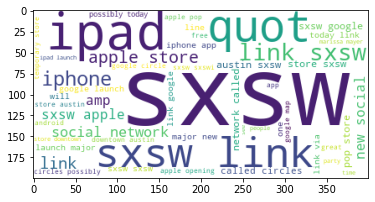

In [ ]:
import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r'@[a-zA-Z0-9_]+', '', text)   
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)   
    text = re.sub(r'www.[^ ]+', '', text)  
    text = re.sub(r'[a-zA-Z0-9]*www[a-zA-Z0-9]*com[a-zA-Z0-9]*', '', text)  
    text = re.sub(r'[^a-zA-Z]', ' ', text)   
    text = [token for token in text.split() if len(token) > 2]
    text = ' '.join(text)
    return text

df['Product_Description'] = df['Product_Description'].apply(clean_text)
from wordcloud import WordCloud, STOPWORDS
wc = WordCloud(background_color='white',
                    stopwords =  set(STOPWORDS),
                    max_words = 50, 
                    random_state = 42,)
wc.generate(' '.join(df['Product_Description']))
plt.imshow(wc)

In [ ]:
import string
punctuation=string.punctuation
df['word_count']=df['Product_Description'].apply(lambda x: len(str(x).split(" ")))
df['char_count'] = df['Product_Description'].str.len()
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/(len(words)+1))

df['avg_word'] = df['Product_Description'].apply(lambda x: avg_word(x))
from nltk.corpus import stopwords
stop = stopwords.words('english')

df['stopwords'] = df['Product_Description'].apply(lambda x: len([x for x in x.split() if x in stop]))
df['word_density'] = df['char_count'] / (df['word_count']+1)


In [ ]:
j=[]
for i in df['Product_Description']:
  j.append(len(i))
df['len']=j

In [ ]:
from textblob import TextBlob
df['polarity'] = df.apply(lambda x: TextBlob(x['Product_Description']).sentiment.polarity, axis=1)
df['subjectivity'] = df.apply(lambda x: TextBlob(x['Product_Description']).sentiment.subjectivity, axis=1)

In [ ]:
df['ID_Type']=df['Product_Type']+df['Text_ID']

In [ ]:
df.head(5)

,Text_ID,Product_Description,Product_Type,Sentiment,numerics,upper,Product_Description_Top_0,Product_Description_Top_1,Product_Description_Top_2,Product_Description_Top_3,Product_Description_Top_4,Product_Description_Top_5,Product_Description_Top_6,Product_Description_Top_7,Product_Description_Top_8,Product_Description_Top_9,Product_Description_Top_10,Product_Description_Top_11,Product_Description_Top_12,Product_Description_Top_13,Product_Description_Top_14,Product_Description_Top_15,Product_Description_Top_16,Product_Description_Top_17,Product_Description_Top_18,Product_Description_Top_19,Product_Description_Top_20,Product_Description_Top_21,Product_Description_Top_22,Product_Description_Top_23,Product_Description_Top_24,Product_Description_Top_25,Product_Description_Top_26,Product_Description_Top_27,Product_Description_Top_28,Product_Description_Top_29,Product_Description_Top_30,Product_Description_Top_31,Product_Description_Top_32,Product_Description_Top_33,...,Product_Description_Top_9969,Product_Description_Top_9970,Product_Description_Top_9971,Product_Description_Top_9972,Product_Description_Top_9973,Product_Description_Top_9974,Product_Description_Top_9975,Product_Description_Top_9976,Product_Description_Top_9977,Product_Description_Top_9978,Product_Description_Top_9979,Product_Description_Top_9980,Product_Description_Top_9981,Product_Description_Top_9982,Product_Description_Top_9983,Product_Description_Top_9984,Product_Description_Top_9985,Product_Description_Top_9986,Product_Description_Top_9987,Product_Description_Top_9988,Product_Description_Top_9989,Product_Description_Top_9990,Product_Description_Top_9991,Product_Description_Top_9992,Product_Description_Top_9993,Product_Description_Top_9994,Product_Description_Top_9995,Product_Description_Top_9996,Product_Description_Top_9997,Product_Description_Top_9998,Product_Description_Top_9999,word_count,char_count,avg_word,stopwords,word_density,len,polarity,subjectivity,ID_Type
0,3057,the web designer guide ios and android apps to...,9,2.0,1,0,0.016153,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,59,4.083333,2,4.916667,59,0.0,0.0,3066
1,6254,line for ipad longer today than yesterday sxsw...,9,2.0,1,2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,92,4.222222,7,5.111111,92,0.3,0.2,6263
2,8212,crazy that apple opening temporary store austi...,9,2.0,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16,98,4.882353,3,5.764706,98,-0.6,0.9,8221
3,4422,the lesson from google one pass this digital e...,9,2.0,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,126,5.095238,4,6.000000,126,0.0,0.0,4431
4,5526,the panel quot your mom has ipad designing for...,9,2.0,0,1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12,64,4.076923,4,4.923077,64,0.0,0.0,5535


In [ ]:
del df['Product_Description']
train = df[df['Sentiment'].isnull()==False]
test = df[df['Sentiment'].isnull()==True]
del test['Sentiment']

In [ ]:
train['Sentiment'].value_counts()

2.0    3765
3.0    2089
1.0     399
0.0     111
Name: Sentiment, dtype: int64

In [ ]:
train_df=train
test_df=test

In [ ]:
X = train_df.drop(labels=['Sentiment'], axis=1)
y = train_df['Sentiment'].values

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.10, random_state=101, stratify=y)

In [ ]:
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape

((5727, 10013), (5727,), (637, 10013), (637,))

In [ ]:
from sklearn.metrics import log_loss

In [ ]:

import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_cv, label=y_cv)

param = {'objective': 'multiclass',
         'num_class': 4,
         'boosting': 'gbdt',  
         'metric': 'multi_logloss',
         'learning_rate': 0.01, 
         'num_iterations': 1000,
         'num_leaves': 31,
         'max_depth': -1,
         'min_data_in_leaf': 15,
         'bagging_fraction':0.9,
         'bagging_freq': 2,
         'feature_fraction': 0.9,
         'lambda_l2': 0.9,
         'min_data_per_group': 75,
         'max_bin': 255,
         'is_unbalance':True
         }

clf = lgb.train(params=param, 
                early_stopping_rounds=200,
                verbose_eval=100,
                train_set=train_data,
                valid_sets=[test_data])

y_pred = clf.predict(X_cv)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.548057
[200]	valid_0's multi_logloss: 0.442063
[300]	valid_0's multi_logloss: 0.408143
[400]	valid_0's multi_logloss: 0.39734
[500]	valid_0's multi_logloss: 0.393411
[600]	valid_0's multi_logloss: 0.394135
[700]	valid_0's multi_logloss: 0.396948
Early stopping, best iteration is:
[516]	valid_0's multi_logloss: 0.393131


In [ ]:
log_loss(y_cv, y_pred)

0.3931310872155192

In [ ]:
import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(), X.columns), reverse=True)[:], columns=['Value','Feature'])
plt.figure(figsize=(20,20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [ ]:
Xtest = test_df

In [ ]:

from sklearn.model_selection import KFold, StratifiedKFold

errlgb = []
y_pred_totlgb = []

fold = StratifiedKFold(n_splits=20, shuffle=True, random_state=2**31)

for train_index, test_index in fold.split(X, y):
    
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)
    
    clf = lgb.train(params=param, 
                     early_stopping_rounds=200,
                     verbose_eval=100,
                     train_set=train_data,
                     valid_sets=[test_data])

    y_pred = clf.predict(X_test)
    print("Log Loss: ", (log_loss(y_test, y_pred)))
    
    errlgb.append(log_loss(y_test, y_pred))
    p = clf.predict(Xtest)
    y_pred_totlgb.append(p)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.565739
[200]	valid_0's multi_logloss: 0.469689
[300]	valid_0's multi_logloss: 0.438956
[400]	valid_0's multi_logloss: 0.430319
[500]	valid_0's multi_logloss: 0.429101
[600]	valid_0's multi_logloss: 0.429873
Early stopping, best iteration is:
[462]	valid_0's multi_logloss: 0.428485
Log Loss:  0.4284851377197714


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.523995
[200]	valid_0's multi_logloss: 0.402702
[300]	valid_0's multi_logloss: 0.358575
[400]	valid_0's multi_logloss: 0.339558
[500]	valid_0's multi_logloss: 0.330265
[600]	valid_0's multi_logloss: 0.327722
[700]	valid_0's multi_logloss: 0.327481
[800]	valid_0's multi_logloss: 0.329514
Early stopping, best iteration is:
[691]	valid_0's multi_logloss: 0.327201
Log Loss:  0.3272007024629862


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.583856
[200]	valid_0's multi_logloss: 0.497139
[300]	valid_0's multi_logloss: 0.471518
[400]	valid_0's multi_logloss: 0.464889
[500]	valid_0's multi_logloss: 0.462169
[600]	valid_0's multi_logloss: 0.46157
[700]	valid_0's multi_logloss: 0.462857
Early stopping, best iteration is:
[586]	valid_0's multi_logloss: 0.460898
Log Loss:  0.46089752831608255


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.559476
[200]	valid_0's multi_logloss: 0.456657
[300]	valid_0's multi_logloss: 0.423676
[400]	valid_0's multi_logloss: 0.414241
[500]	valid_0's multi_logloss: 0.41071
[600]	valid_0's multi_logloss: 0.408317
[700]	valid_0's multi_logloss: 0.407642
[800]	valid_0's multi_logloss: 0.409403
Early stopping, best iteration is:
[689]	valid_0's multi_logloss: 0.406901
Log Loss:  0.40690062930943166


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.535993
[200]	valid_0's multi_logloss: 0.426913
[300]	valid_0's multi_logloss: 0.387437
[400]	valid_0's multi_logloss: 0.369745
[500]	valid_0's multi_logloss: 0.360131
[600]	valid_0's multi_logloss: 0.353724
[700]	valid_0's multi_logloss: 0.349676
[800]	valid_0's multi_logloss: 0.348047
[900]	valid_0's multi_logloss: 0.347473
[1000]	valid_0's multi_logloss: 0.349038
Did not meet early stopping. Best iteration is:
[862]	valid_0's multi_logloss: 0.347321
Log Loss:  0.34732079957151424


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.563161
[200]	valid_0's multi_logloss: 0.465076
[300]	valid_0's multi_logloss: 0.432288
[400]	valid_0's multi_logloss: 0.422074
[500]	valid_0's multi_logloss: 0.415576
[600]	valid_0's multi_logloss: 0.412185
[700]	valid_0's multi_logloss: 0.412775
[800]	valid_0's multi_logloss: 0.414338
Early stopping, best iteration is:
[624]	valid_0's multi_logloss: 0.412069
Log Loss:  0.4120694559165634


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.554324
[200]	valid_0's multi_logloss: 0.459481
[300]	valid_0's multi_logloss: 0.427813
[400]	valid_0's multi_logloss: 0.420384
[500]	valid_0's multi_logloss: 0.417286
[600]	valid_0's multi_logloss: 0.415854
[700]	valid_0's multi_logloss: 0.417897
Early stopping, best iteration is:
[595]	valid_0's multi_logloss: 0.415649
Log Loss:  0.41564893942715364


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.553803
[200]	valid_0's multi_logloss: 0.453816
[300]	valid_0's multi_logloss: 0.42065
[400]	valid_0's multi_logloss: 0.408434
[500]	valid_0's multi_logloss: 0.402771
[600]	valid_0's multi_logloss: 0.39996
[700]	valid_0's multi_logloss: 0.399455
[800]	valid_0's multi_logloss: 0.401941
Early stopping, best iteration is:
[663]	valid_0's multi_logloss: 0.399216
Log Loss:  0.3992159567958863


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.569071
[200]	valid_0's multi_logloss: 0.483996
[300]	valid_0's multi_logloss: 0.458717
[400]	valid_0's multi_logloss: 0.45303
[500]	valid_0's multi_logloss: 0.455839
Early stopping, best iteration is:
[395]	valid_0's multi_logloss: 0.452758
Log Loss:  0.4527584900513695


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.555665
[200]	valid_0's multi_logloss: 0.464878
[300]	valid_0's multi_logloss: 0.434328
[400]	valid_0's multi_logloss: 0.426612
[500]	valid_0's multi_logloss: 0.425775
[600]	valid_0's multi_logloss: 0.428257
[700]	valid_0's multi_logloss: 0.431428
Early stopping, best iteration is:
[508]	valid_0's multi_logloss: 0.425303
Log Loss:  0.4253034800583961


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.560389
[200]	valid_0's multi_logloss: 0.463166
[300]	valid_0's multi_logloss: 0.431809
[400]	valid_0's multi_logloss: 0.419748
[500]	valid_0's multi_logloss: 0.414606
[600]	valid_0's multi_logloss: 0.412139
[700]	valid_0's multi_logloss: 0.412592
Early stopping, best iteration is:
[586]	valid_0's multi_logloss: 0.411719
Log Loss:  0.41171908485988296


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.543943
[200]	valid_0's multi_logloss: 0.448177
[300]	valid_0's multi_logloss: 0.422225
[400]	valid_0's multi_logloss: 0.415982
[500]	valid_0's multi_logloss: 0.416505
[600]	valid_0's multi_logloss: 0.421326
Early stopping, best iteration is:
[444]	valid_0's multi_logloss: 0.415046
Log Loss:  0.41504647959029173


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.557038
[200]	valid_0's multi_logloss: 0.460101
[300]	valid_0's multi_logloss: 0.431001
[400]	valid_0's multi_logloss: 0.421904
[500]	valid_0's multi_logloss: 0.419398
[600]	valid_0's multi_logloss: 0.418892
[700]	valid_0's multi_logloss: 0.421586
Early stopping, best iteration is:
[572]	valid_0's multi_logloss: 0.418664
Log Loss:  0.4186636049696577


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.55458
[200]	valid_0's multi_logloss: 0.444116
[300]	valid_0's multi_logloss: 0.407422
[400]	valid_0's multi_logloss: 0.390961
[500]	valid_0's multi_logloss: 0.383894
[600]	valid_0's multi_logloss: 0.382456
[700]	valid_0's multi_logloss: 0.384616
Early stopping, best iteration is:
[598]	valid_0's multi_logloss: 0.382401
Log Loss:  0.382400529203833


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.566076
[200]	valid_0's multi_logloss: 0.469461
[300]	valid_0's multi_logloss: 0.435494
[400]	valid_0's multi_logloss: 0.420331
[500]	valid_0's multi_logloss: 0.413115
[600]	valid_0's multi_logloss: 0.411135
[700]	valid_0's multi_logloss: 0.411438
[800]	valid_0's multi_logloss: 0.413648
Early stopping, best iteration is:
[669]	valid_0's multi_logloss: 0.410776
Log Loss:  0.4107760381984167


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.556707
[200]	valid_0's multi_logloss: 0.457817
[300]	valid_0's multi_logloss: 0.429674
[400]	valid_0's multi_logloss: 0.42278
[500]	valid_0's multi_logloss: 0.422575
[600]	valid_0's multi_logloss: 0.425657
Early stopping, best iteration is:
[432]	valid_0's multi_logloss: 0.4222
Log Loss:  0.422199983606301


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.555856
[200]	valid_0's multi_logloss: 0.460773
[300]	valid_0's multi_logloss: 0.430946
[400]	valid_0's multi_logloss: 0.42431
[500]	valid_0's multi_logloss: 0.42248
[600]	valid_0's multi_logloss: 0.42392
[700]	valid_0's multi_logloss: 0.425687
Early stopping, best iteration is:
[528]	valid_0's multi_logloss: 0.421928
Log Loss:  0.4219277678768718


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.548315
[200]	valid_0's multi_logloss: 0.448313
[300]	valid_0's multi_logloss: 0.415344
[400]	valid_0's multi_logloss: 0.403218
[500]	valid_0's multi_logloss: 0.398415
[600]	valid_0's multi_logloss: 0.399325
[700]	valid_0's multi_logloss: 0.40263
Early stopping, best iteration is:
[530]	valid_0's multi_logloss: 0.398081
Log Loss:  0.39808132252727035


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.586321
[200]	valid_0's multi_logloss: 0.503204
[300]	valid_0's multi_logloss: 0.48323
[400]	valid_0's multi_logloss: 0.48231
[500]	valid_0's multi_logloss: 0.488052
Early stopping, best iteration is:
[352]	valid_0's multi_logloss: 0.480716
Log Loss:  0.48071578664520204


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's multi_logloss: 0.559838
[200]	valid_0's multi_logloss: 0.460484
[300]	valid_0's multi_logloss: 0.425215
[400]	valid_0's multi_logloss: 0.410507
[500]	valid_0's multi_logloss: 0.40115
[600]	valid_0's multi_logloss: 0.395746
[700]	valid_0's multi_logloss: 0.391345
[800]	valid_0's multi_logloss: 0.390256
[900]	valid_0's multi_logloss: 0.391602
Early stopping, best iteration is:
[780]	valid_0's multi_logloss: 0.389945
Log Loss:  0.38994489939130056


In [ ]:
np.mean(errlgb,0)

0.4113638308249091

In [ ]:
'''
x=[]
for i in errlgb:
  if i>0.43:
    xx=errlgb.index(i)
    x.append(xx)
x=sorted(x, reverse=True)
print(x)
for i in x:
  del y_pred_totlgb[i]
  del errlgb[i]
'''

[9, 4, 3]

In [ ]:
y_pred = np.mean(y_pred_totlgb,0)

In [ ]:
submission = pd.DataFrame(data=y_pred, columns=sub.columns)
submission.head()

,0,1,2,3
0,0.001124,0.023857,0.026353,0.948667
1,0.029278,0.021938,0.865043,0.083742
2,0.006872,0.007179,0.919813,0.066136
3,0.000894,0.032677,0.035199,0.931231
4,0.008524,0.009883,0.926684,0.054909


In [ ]:
submission.to_csv('Mh13.csv', index=False)

# r1

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import log_loss
from tqdm import tqdm_notebook
from sklearn.utils import shuffle

In [ ]:
TARGET_COL ='Sentiment'
train, test = df.iloc[:train.shape[0]], df.iloc[train.shape[0]:]
test.reset_index(drop=True, inplace=True)
target = train[TARGET_COL]
features = [c for c in train.columns if c not in [TARGET_COL]]

In [ ]:
X_trn, X_val, y_trn, y_val = train_test_split(train[features], target, test_size=0.10, stratify=target, random_state=101)
X_test = test[features]

In [ ]:
clf = LGBMClassifier(boosting='gbdt',learning_rate=0.01, n_estimators=1000,num_leaves=31)
_ = clf.fit(X_trn, y_trn, eval_set=[(X_trn, y_trn), (X_val, y_val)], verbose=100, early_stopping_rounds=100)
predictions_val_lgb = clf.predict_proba(X_val)
print(f"Log loss for Model 1 is: {log_loss(y_val, predictions_val_lgb)}")

Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.470689	valid_1's multi_logloss: 0.534132
[200]	training's multi_logloss: 0.327146	valid_1's multi_logloss: 0.437191
[300]	training's multi_logloss: 0.256612	valid_1's multi_logloss: 0.408668
[400]	training's multi_logloss: 0.2118	valid_1's multi_logloss: 0.402501
[500]	training's multi_logloss: 0.176346	valid_1's multi_logloss: 0.400943
Early stopping, best iteration is:
[480]	training's multi_logloss: 0.182662	valid_1's multi_logloss: 0.400787
Log loss for Model 1 is: 0.4007872709033161


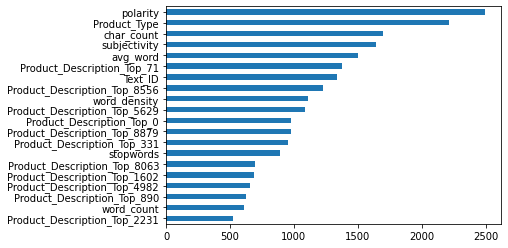

In [ ]:
fi = pd.Series(index=features, data = clf.feature_importances_)
fi.sort_values(ascending=False)[:20][::-1].plot.barh()

In [ ]:
predictions_test_lgb = clf.predict_proba(X_test)

In [ ]:
submission = pd.DataFrame(data=predictions_test_lgb, columns=sub.columns)
submission.head()

,0,1,2,3
0,0.001591,0.025534,0.035470,0.937405
1,0.018560,0.015505,0.881807,0.084128
2,0.005965,0.009453,0.898941,0.085642
3,0.001241,0.046230,0.026620,0.925909
4,0.009184,0.003723,0.930938,0.056155


In [ ]:
submission.to_csv('Mh9.csv', index=False)